In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
sns.set_context("paper")
sns.set(style="whitegrid")

In [2]:
def makeDataFrameFromFile(filename, percentage):
    with open(filename) as openfileobject:
        acc_before_pruning = []
        acc_after_pruning = []
        batches = []
        filters_per_layer = []
        full_accuracy_list = []
        for line in openfileobject:
            if "Accuracy" in line or "accuracy" in line:
                if "Couldn't reach original accuracy" in line: 
                    continue
                number = float(line.split("%")[0].split(" ")[-1])
                full_accuracy_list.append(number)
            if "INFO:lightnet.FLIR.prune:[" in line and "Pruned" not in line:
                layer = []
                string = line.split("INFO:lightnet.FLIR.prune:[")[1].split("]")[0]
                layer = string.split(", ")
                count = 0
                for filter in layer:
                    layer[count] = float(filter)
                    count += 1 
                filters_per_layer.append(layer)
            if "Trained for" in line:
                number = float(line.split("Trained for ")[1].split(" batches")[0])
                batches.append(number)
            if "Original accuracy" in line:
                number = float(line.split("INFO:lightnet.FLIR.prune:Original accuracy is ")[1].split("%")[0])
                acc_before_pruning.append(number)
            elif "Accuracy after retraining" in line:
                number = float(line.split("Accuracy after retraining: ")[1].split("%")[0])
                acc_before_pruning.append(number)
            elif "Accuracy after pruning" in line:
                number = float(line.split("Accuracy after pruning: ")[1].split("%")[0])
                acc_after_pruning.append(number)
        
        percentage_pruned = []
        for number in range(len(acc_before_pruning)+1):
            percentage_pruned.append(round(100*(1-(1 - (percentage / 100))**(number+1)),2))

        data = []
        for iteration in range(len(acc_after_pruning)):
            i = []
            i.append(acc_before_pruning[iteration])
            i.append(acc_after_pruning[iteration])
            i.append(acc_before_pruning[iteration] - acc_after_pruning[iteration])
            i.append(percentage_pruned[iteration])
            i.append(batches[iteration])
            if batches[iteration] == 10000:
                i.append(False)
            else:
                i.append(True)
            data.append(i)
        i = [acc_before_pruning[len(acc_before_pruning)-1], None, None, percentage_pruned[len(acc_before_pruning)-1]]
        data.append(i)

        accuracy = pd.DataFrame(data, columns = ['Before pruning', 'After pruning', 'Accuracy loss',\
                                                 'Percentage pruned', 'Batches trained' , 'Top limit'])
        return accuracy, filters_per_layer, full_accuracy_list

In [3]:
def printAccuracy(accuracy):
    # Accuracy before vs after pruning
    plt.subplots(figsize=(12, 8))
    #plt.ylim(0, 100)
    plot = sns.barplot(x='Percentage pruned' ,y='Before pruning', data=accuracy, color='#557000')
    plot = sns.barplot(x='Percentage pruned' ,y='After pruning', data=accuracy, color='#639c0e')
    plot.set(xlabel = 'Percentage pruned [%]', ylabel = 'Accuracy [%]')

In [4]:
def printAccuracyLoss(accuracy):
    # Accuracy drop from pruning
    plt.subplots(figsize=(12, 8))
    #plt.ylim(0, 100)
    plot = sns.barplot(x='Percentage pruned' ,y='Accuracy loss', data=accuracy, color='#9c150e')
    plot.set(xlabel = 'Percentage pruned [%]', ylabel = 'Accuracy loss [%]')

In [5]:
def printFiltersPerLayer(filters):
    # FiltersPerLayer before and after being pruned
  
    index = []
    for i in range(len(filters[0])):
        index.append([filters[0][i], filters[1][i]])
    
    amount = pd.DataFrame(index, columns = ['Unpruned', 'Pruned'])
    
    plt.subplots(figsize=(12, 8))
    plot = sns.barplot(x=amount.index, y='Unpruned', data=amount, color='#557000')
    plot = sns.barplot(x=amount.index, y='Pruned', data=amount, color='#639c0e')
    plot.set(xlabel = 'Convolution layer', ylabel = 'Amount of filters')

In [6]:
def printFiltersPerLayerPercentage(filters):
    # FiltersPerLayer before and after being pruned
  
    index = []
    for i in range(len(filters[0])):
        percentage = 100*(filters[0][i]-filters[1][i])/filters[0][i]
        index.append(percentage)
    
    amount = pd.DataFrame(index, columns = ['Percentage pruned'])
    
    plt.subplots(figsize=(12, 8))
    plot = sns.barplot(x=amount.index, y='Percentage pruned', data=amount, color='#9c150e')
    plot.set(xlabel = 'Convolution layer', ylabel = 'Amount of filters pruned [%]')

In [7]:
def getFiltersOfLayers(filters_per_layer, layer1, layer2):
    filters = []
    filters.append(filters_per_layer[layer1])
    filters.append(filters_per_layer[layer2])
    return filters

In [8]:
def printFullAccuracyGraph(full_accuracy_list):
    df = pd.DataFrame(full_accuracy_list, columns = ['Accuracy'])
    
    plt.subplots(figsize=(12, 8))
    plot = sns.lineplot(x=df.index, y='Accuracy', data=df, color='#9c150e')
    plot.set(xlabel = 'Epoch', ylabel = 'Accuracy [%]')

In [9]:
firstMethod, filters_per_layer, full_accuracy_list = makeDataFrameFromFile('logs/l2-hard-10.log', 10)
secondMethod, filters_per_layer_second, second_full_accuracy_list = makeDataFrameFromFile('logs/l2-hard-7.5.log', 7.5)

filters = getFiltersOfLayers(filters_per_layer, 0, -1)
filtersearly = getFiltersOfLayers(filters_per_layer, 0, 4)     

secondfilters = getFiltersOfLayers(filters_per_layer, 0, -1)
secondfiltersearly = getFiltersOfLayers(filters_per_layer, 0, 4)  

print(firstMethod)
print(secondMethod)
#print(filters)

    Before pruning  After pruning  Accuracy loss  Percentage pruned  \
0            65.68          64.07           1.61              10.00   
1            66.88          47.18          19.70              19.00   
2            66.12          50.27          15.85              27.10   
3            65.78          44.92          20.86              34.39   
4            65.89          36.65          29.24              40.95   
5            65.99          34.39          31.60              46.86   
6            65.05          20.09          44.96              52.17   
7            65.08          34.10          30.98              56.95   
8            65.09          25.26          39.83              61.26   
9            65.12          20.82          44.30              65.13   
10           65.26          35.14          30.12              68.62   
11           65.36          10.78          54.58              71.76   
12           64.38           6.46          57.92              74.58   
13    

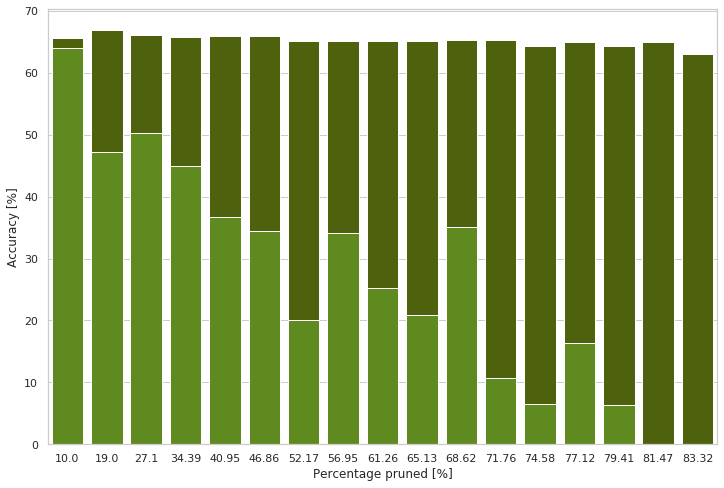

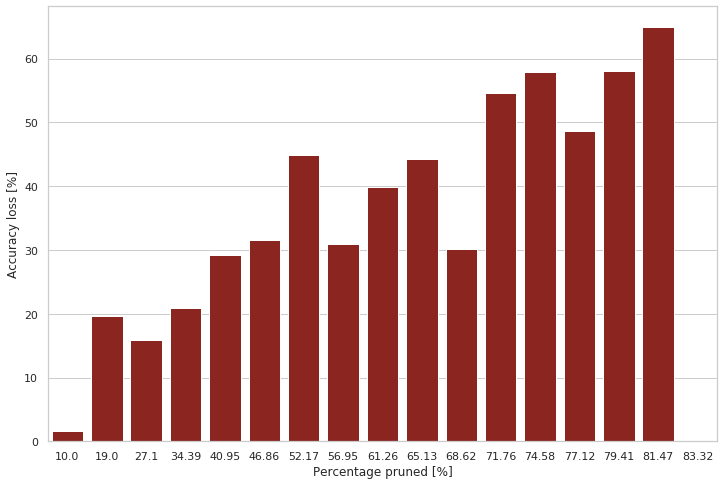

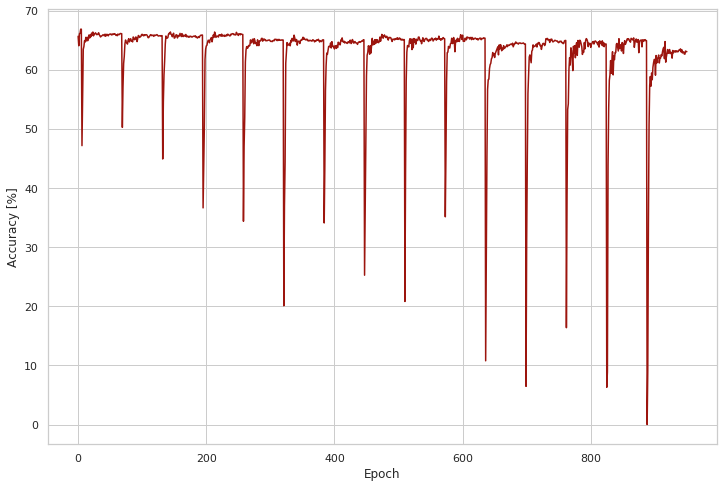

In [10]:
printAccuracy(firstMethod)
printAccuracyLoss(firstMethod)
printFullAccuracyGraph(full_accuracy_list)

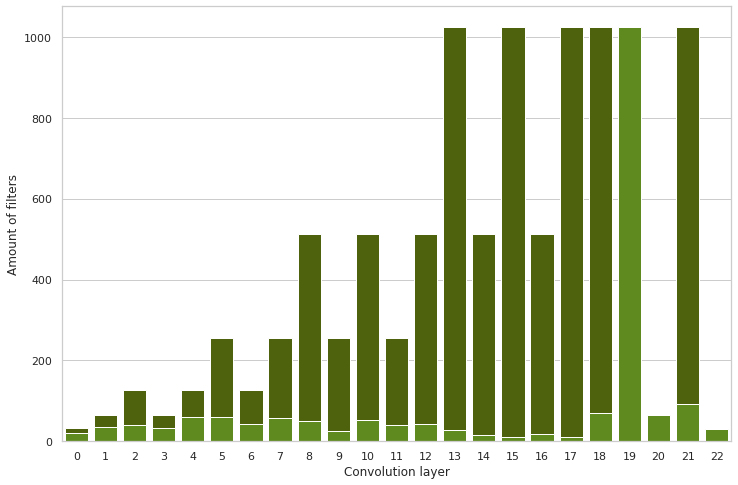

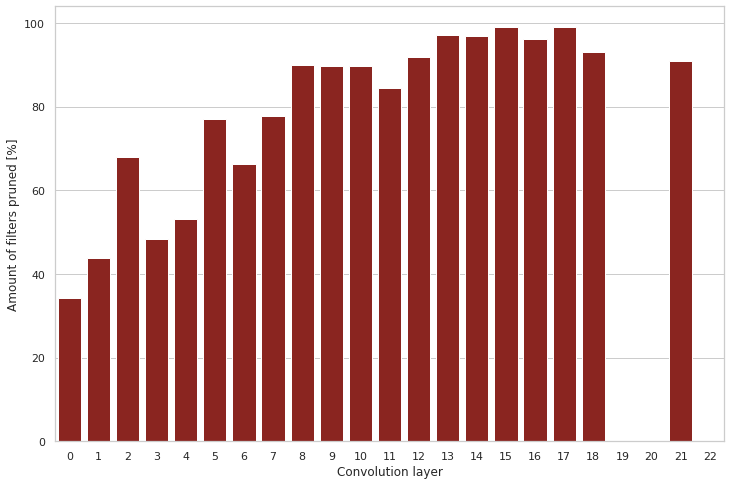

In [11]:
printFiltersPerLayer(filters)
printFiltersPerLayerPercentage(filters)

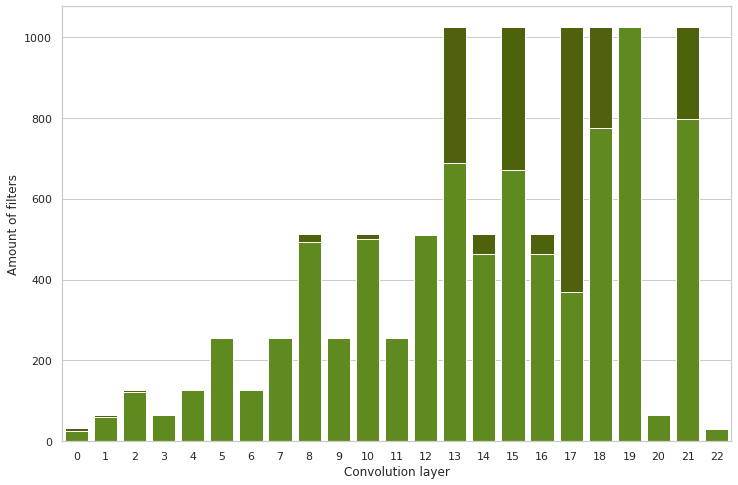

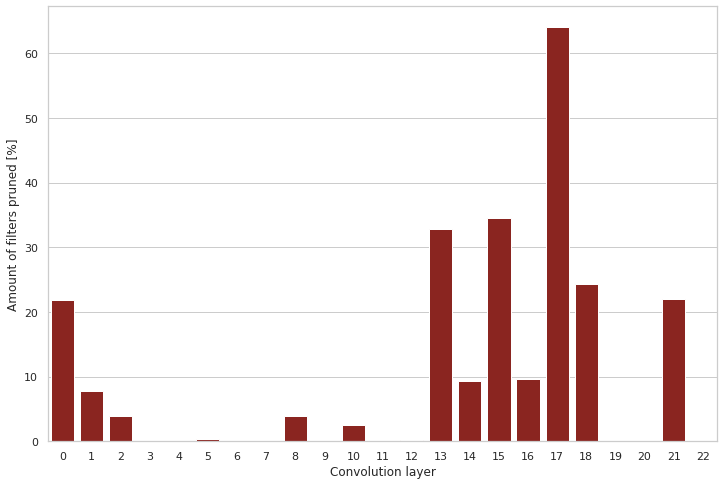

In [12]:
printFiltersPerLayer(filtersearly)
printFiltersPerLayerPercentage(filtersearly)

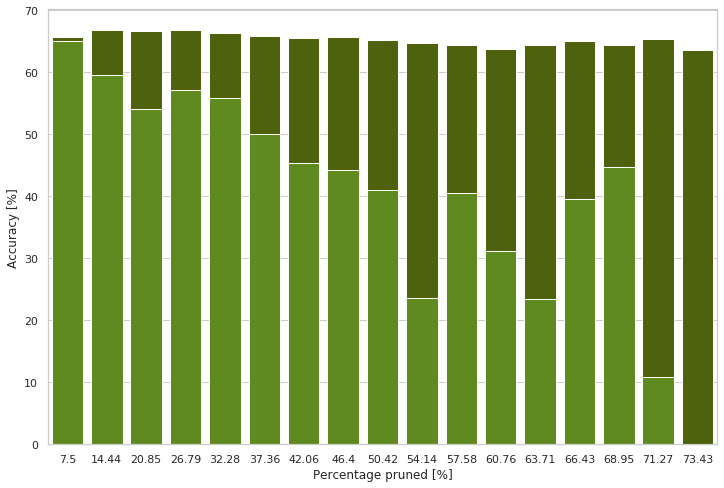

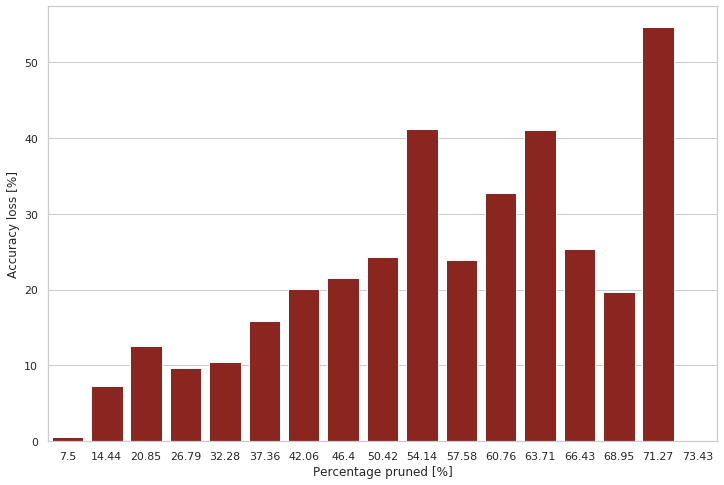

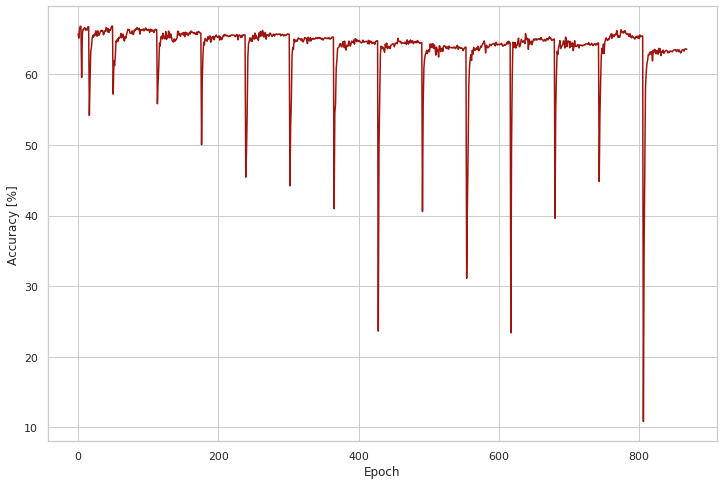

In [13]:
# TWEEDE MODEL
printAccuracy(secondMethod)
printAccuracyLoss(secondMethod)
printFullAccuracyGraph(second_full_accuracy_list)

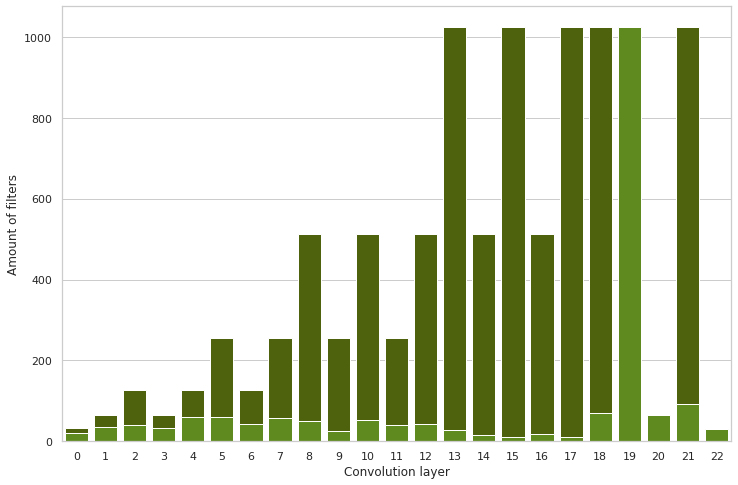

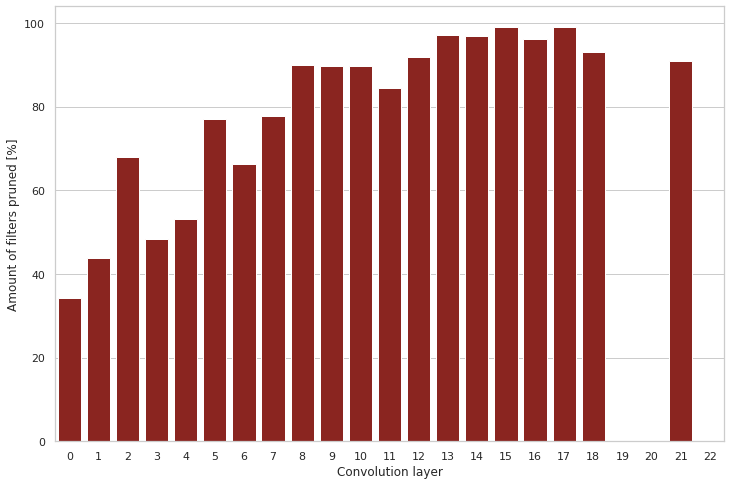

In [14]:
printFiltersPerLayer(secondfilters)
printFiltersPerLayerPercentage(secondfilters)

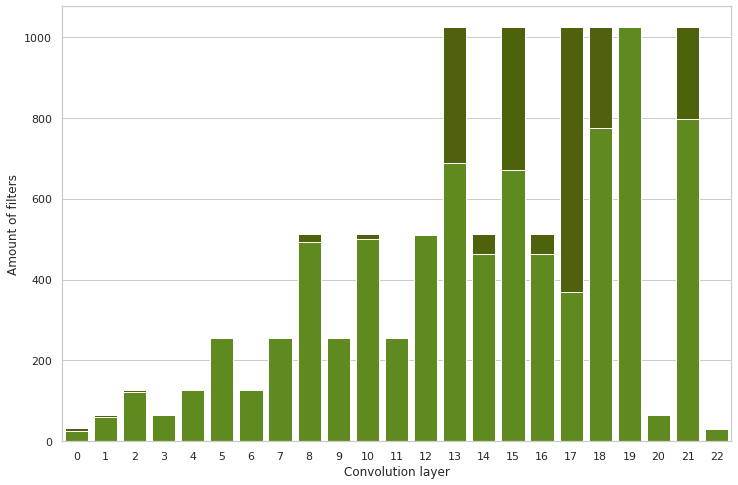

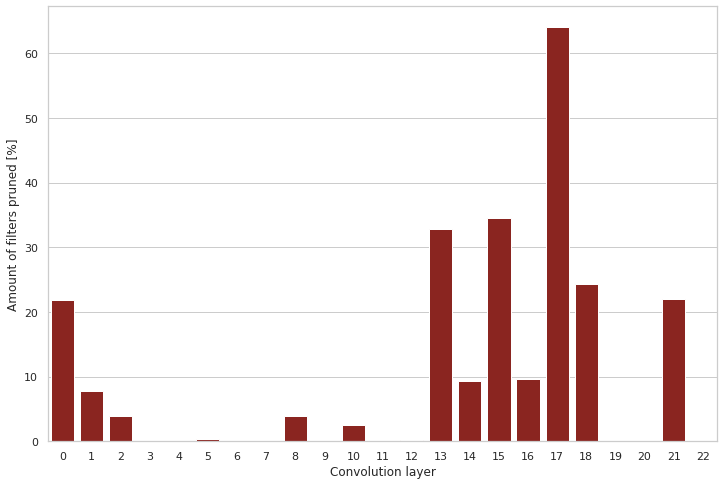

In [15]:
printFiltersPerLayer(secondfiltersearly)
printFiltersPerLayerPercentage(secondfiltersearly)